# CREATE THE SENTENCES RESPONSIBLE FOR THE SCATTER: 
***

In [18]:
import openai
from openai import OpenAI
import math
import torch
import pandas as pd
import os 
import vec2text
from openai.resources import embeddings as OpenAI_embed_class

key = "sk-proj-qkvfLuY17OrXweVBFwf3T3BlbkFJRQisxXitvKVkwVi3Dq7m"
os.environ["OPENAI_API_KEY"] = key




In [19]:
!openai --version

openai 1.2.0


In [24]:
client = OpenAI(api_key=key)
corrector = vec2text.load_pretrained_corrector("text-embedding-ada-002")
embed_Class = OpenAI_embed_class.Embeddings(client)


def get_embeddings_openai(text_list, model="text-embedding-ada-002") -> torch.Tensor:
    batches = math.ceil(len(text_list) / 128)
    outputs = []
    for batch in range(batches):
        text_list_batch = text_list[batch * 128 : (batch + 1) * 128]
        response = embed_Class.create(
            input=text_list_batch,

            model=model,
            encoding_format="float",  # override default base64 encoding...
        )
    outputs.extend([e.embedding for e in response.data])
    return torch.tensor(outputs)


#Trying to generate outputs from openai gpt4o model
model_engine = "gpt-4o"

prompt = "Hello I was wondering if you could generate me 50 randomly generated sentences. These sentences can be of any length measuring from 1-infinite words. I'd probably make the sentences of a regular length so nothing absurd please. These sentences can also be of any topic. I would try to limit the use of wordiness in your words. Don't add any unnessesary words to the prompt if it's not needed.\n\n I would like the sentences to be outputted in a python list.\nfor example: Output -> [\"sentence1\", \"sentence2\", \"other sentences\"]\nCould you please do this for me?\n Make sure to output no other responce other than the list itself. I don't want you to say anything"

completion = client.chat.completions.create(
    model=model_engine,
    messages=[{"role": "system", "content": "You are a helpful assistant"},
              {"role": "user", "content": prompt}
              ]
)

# Extract the output
output = completion.choices[0].message.content
print(output)


["The sun set behind the mountains.", "She loves to read books.", "The dog barked loudly.", "They went for a hike.", "He cooked dinner for us.", "The movie was entertaining.", "She painted a beautiful picture.", "The cat slept on the couch.", "He built a treehouse.", "The river flowed peacefully.", "She planted flowers in the garden.", "He drove to the beach.", "The rain fell gently.", "They played soccer in the park.", "She baked a chocolate cake.", "The wind blew through the trees.", "He wrote a letter to his friend.", "The kids drew with chalk on the sidewalk.", "She danced to her favorite song.", "The stars twinkled in the night sky.", "He fixed the broken chair.", "She knitted a scarf for winter.", "The fire crackled in the fireplace.", "They sang songs around the campfire.", "He repaired the old bicycle.", "She cleaned the kitchen.", "The birds chirped in the morning.", "He read a story to his daughter.", "The snow covered the ground.", "She sewed a new dress.", "He played the pi

In [33]:
#Get the embeddings from openai genereated sentences: 
embeddings = get_embeddings_openai(output)

In [34]:
print(embeddings)

tensor([[-0.0105, -0.0082,  0.0058,  ..., -0.0259,  0.0134, -0.0114],
        [-0.0037, -0.0308, -0.0018,  ..., -0.0150,  0.0064, -0.0201],
        [-0.0055,  0.0015, -0.0016,  ..., -0.0250,  0.0021, -0.0088],
        ...,
        [ 0.0047, -0.0150,  0.0076,  ..., -0.0005, -0.0114, -0.0091],
        [ 0.0007, -0.0003,  0.0021,  ..., -0.0151, -0.0028, -0.0147],
        [-0.0044, -0.0143, -0.0053,  ..., -0.0082,  0.0105, -0.0258]])


# START OF NN: 
***

In [21]:
import vec2text
import torch
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer, PreTrainedModel
import numpy as np

def get_gtr_embeddings(text_list,
                       encoder: PreTrainedModel,
                       tokenizer: PreTrainedTokenizer) -> torch.Tensor:

    inputs = tokenizer(text_list,
                       return_tensors="pt",
                       max_length=128,
                       truncation=True,
                       padding="max_length",).to("cuda")

    with torch.no_grad():
        model_output = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        hidden_state = model_output.last_hidden_state
        embeddings = vec2text.models.model_utils.mean_pool(hidden_state, inputs['attention_mask'])

    return embeddings


encoder = AutoModel.from_pretrained("sentence-transformers/gtr-t5-base").encoder.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/gtr-t5-base")
corrector = vec2text.load_pretrained_corrector("gtr-base")

/home/brody/BrodyCode/ProfCode/ipynb/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of T5Model were not initialized from the model checkpoint at sentence-transformers/gtr-t5-base and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.weig

In [22]:
import pandas as pd
from matplotlib.widgets import Button
from umap import UMAP

data = pd.read_csv("/home/brody/BrodyCode/ProfCode/toy2dquotes.csv")

# Extract the quotes from the data
quotes = data['quote'].tolist()

# Use the T5 model to generate embeddings for the quotes
quote_embeddings = get_gtr_embeddings(quotes, encoder, tokenizer)

# Convert the embeddings to a numpy array
quote_embeddings = np.array([x.cpu().numpy().T for x in quote_embeddings])

# Use UMAP to reduce the dimensionality of the embeddings
umap = UMAP(n_neighbors=10, min_dist=0.3, metric='cosine', random_state=42).fit(quote_embeddings)
quote_embedding = umap.transform(quote_embeddings)

# Create a dataframe from the embeddings
df_quotes = pd.DataFrame(quote_embedding, columns=['x', 'y'])

/home/brody/BrodyCode/ProfCode/ipynb/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
import pandas as pd

heart = pd.read_csv("/home/brody/BrodyCode/ProfCode/toy2danchorpoints.csv",header=None)
heart.columns =['x','y']

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
mms = MinMaxScaler(feature_range=(2,7))
scaled_heart = mms.fit_transform(heart)
print(scaled_heart)

df_scaled_heart = pd.DataFrame(scaled_heart, columns=['x', 'y'])
df_scaled_heart.to_json('~/BrodyCode/ProfCode/ScaledHeart_Embeddings.jsonl', orient='records', lines=True)




[[4.64357536 2.        ]
 [3.81386561 2.5180202 ]
 [2.70339715 4.16320039]
 [2.6690527  4.33667827]
 [2.         5.73117287]
 [2.68406209 6.214066  ]
 [3.63969719 7.        ]
 [4.12155805 5.88768654]
 [5.28369921 6.98689388]
 [6.92332402 6.04449028]
 [7.         4.54691462]
 [5.13482428 2.22691523]]


In [36]:
mms2 = MinMaxScaler(feature_range=(2,7))
quote_embeddings_scaled = mms2.fit_transform(quote_embedding)

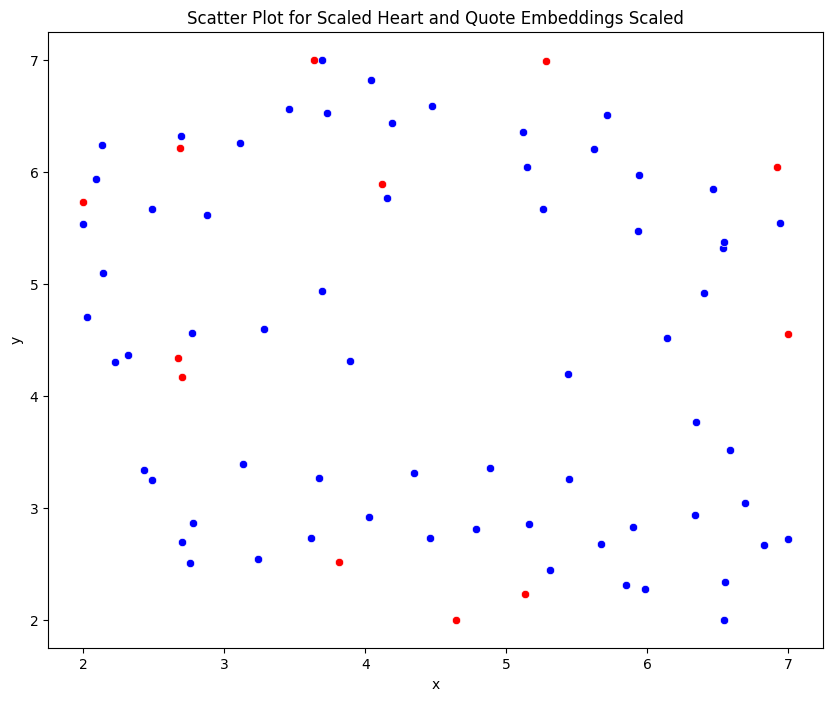

In [37]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Create a DataFrame from the scaled heart data
df_scaled_heart = pd.DataFrame(scaled_heart, columns=['x', 'y'])

# Create a DataFrame from the quote embeddings scaled data
df_quote_embeddings_scaled = pd.DataFrame(quote_embeddings_scaled, columns=['x', 'y'])

# Plot the scaled heart data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_scaled_heart, x='x', y='y', color='red')

# Overlay the quote embeddings scaled data
sns.scatterplot(data=df_quote_embeddings_scaled, x='x', y='y', color='blue')

plt.title('Scatter Plot for Scaled Heart and Quote Embeddings Scaled')
plt.show()


In [63]:
#Combine both the dataframes into one jsonl: 

import pandas as pd


combined_df = pd.concat([df_scaled_heart, df_quote_embeddings_scaled])
combined_df.to_json('~/BrodyCode/ProfCode/ScaledHeart_Scatter_Embeddings.jsonl', orient='records', lines=True)


In [55]:
from scipy.spatial import distance_matrix


# Compute pairwise distances
distances = distance_matrix(df_scaled_heart.values, df_quote_embeddings_scaled.values)

# Convert to DataFrame
# df_distances = pd.DataFrame(distances, columns=df_quote_embeddings_scaled.index, index=df_scaled_heart.index)


In [39]:
print(distances.shape)

(12, 65)


In [40]:
nearest_points = np.unique(distances.argmin(axis=1))

In [41]:
nearest_points

array([ 1,  4,  7, 15, 27, 32, 43, 47, 52, 55, 57])

In [42]:
embedding_landmarks = quote_embeddings[nearest_points]

In [43]:
embedding_landmarks.shape

(11, 768)

In [44]:
#BRODY RUN THIS CELL FOR THE SAKE OF HUMANITY: 


mixed_embeddings_landmarks = []
mixed_text_landmarks = []
for i in range(len(embedding_landmarks)):
    try:
        start = embedding_landmarks[i]
        end = embedding_landmarks[i+1]
    except IndexError:
        start = embedding_landmarks[-1]
        end = embedding_landmarks[0]

    for alpha in np.arange(0.0, 1.0, 0.1):
        mixed_embedding = torch.lerp(input=torch.tensor(start).to('cuda'), end=torch.tensor(end).to('cuda'), weight=alpha)
        text = vec2text.invert_embeddings(
            embeddings=mixed_embedding[None].cuda(),
            corrector=corrector,
            #editied step so that I can test better with the data for the front end portions of the project: 

            
            num_steps=10,
            sequence_beam_width=4,
        )[0]
        print(f'alpha={alpha:.1f}\t', text)
        mixed_embeddings_landmarks.append(mixed_embedding)
        mixed_text_landmarks.append(text)

alpha=0.0	 I spent a few minutes playing with a local friend and had a truly memorable moment when I decided to share some new insights. 
alpha=0.1	 I spent a chance to play with a local friend and had a truly memorable moment of sharing and a lot of interesting new insights. 
alpha=0.2	 I spent some time playing with a local friend and managed to share and engage with a new mind and a truly memorable moment of insights. 
alpha=0.3	 I spent a fun time playing with a local friend and had a truly memorable moment in a shared local experience that successfully raised new insights.
alpha=0.4	 I shared a meal with a local friend while playing with a local participant and successfully raised a new and even more memorable mind and insight...
alpha=0.5	 I had the opportunity to play a shared lunch with a local friend and successfully raised my mind and insights in a truly memorable and entertaining presence.
alpha=0.6	 Participating in a shared lunch with a local friend successfully raised my 

In [45]:
mixed_embeddings_landmarks

[tensor([-1.0078e-02,  3.1482e-02, -1.7383e-02,  1.6665e-02,  7.3785e-02,
         -3.0339e-02,  1.3601e-02,  6.3474e-03, -4.8381e-02, -3.3943e-02,
          1.0713e-02,  2.9815e-02,  5.6371e-02,  2.9916e-02,  1.4827e-02,
          1.2599e-02,  1.4077e-03,  9.1037e-02,  2.4639e-02, -3.9034e-02,
         -3.3161e-02, -4.8297e-03,  1.4651e-02, -3.7094e-02, -1.1256e-02,
         -5.5342e-02,  1.0035e-02, -4.0258e-02, -2.0421e-02,  1.9433e-02,
         -3.1057e-02,  3.0235e-02,  7.1901e-02, -9.0467e-02,  6.1521e-02,
         -1.3567e-02, -1.9650e-02,  4.1251e-02,  7.1703e-02, -2.9470e-03,
          5.5942e-02, -4.4255e-03,  3.6247e-02, -3.1176e-02, -1.5271e-02,
          5.5657e-03, -2.4902e-02,  1.6240e-03, -9.6382e-03,  1.8815e-02,
          2.0859e-02,  1.3854e-02, -8.9056e-03,  2.1967e-03, -1.0620e-02,
         -1.4024e-02,  2.8343e-02, -5.9392e-02, -6.5487e-02, -1.1306e-02,
         -4.4792e-02, -1.2362e-02,  1.4699e-02, -1.6021e-02, -3.2894e-02,
         -6.3180e-02, -6.0416e-02,  4.

In [46]:
mixed_embeddings_landmarks_cpu = np.array([x.cpu().numpy().T for x in mixed_embeddings_landmarks])

In [ ]:
embeds = umap.transform(mixed_embeddings_landmarks_cpu)

# Create a DataFrame from the embeddings
df_embeds = pd.DataFrame(embeds, columns=['x', 'y'])


#TODO: ADD THE QUOTES TO THIS jsonl file. 
# Save DataFrame to a JsonL file: 
df_embeds.to_json('~/BrodyCode/ProfCode/NearestNeighborEmbeddings.jsonl', orient='records', lines=True)



# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_embeds, x='x', y='y')
plt.title('UMAP Scatter Plot for Mixed Embeddings')



# # Adding text labels to the scatter plot
# for line in range(0, df_embeds.shape[0]):
#      scatter.text(df_embeds.x[line]+0.2, df_embeds.y[line], 
#      df_embeds.index[line], horizontalalignment='left', 
#      size='medium', color='black', weight='semibold')

plt.show()

/home/brody/BrodyCode/ProfCode/ipynb/.venv/lib/python3.10/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


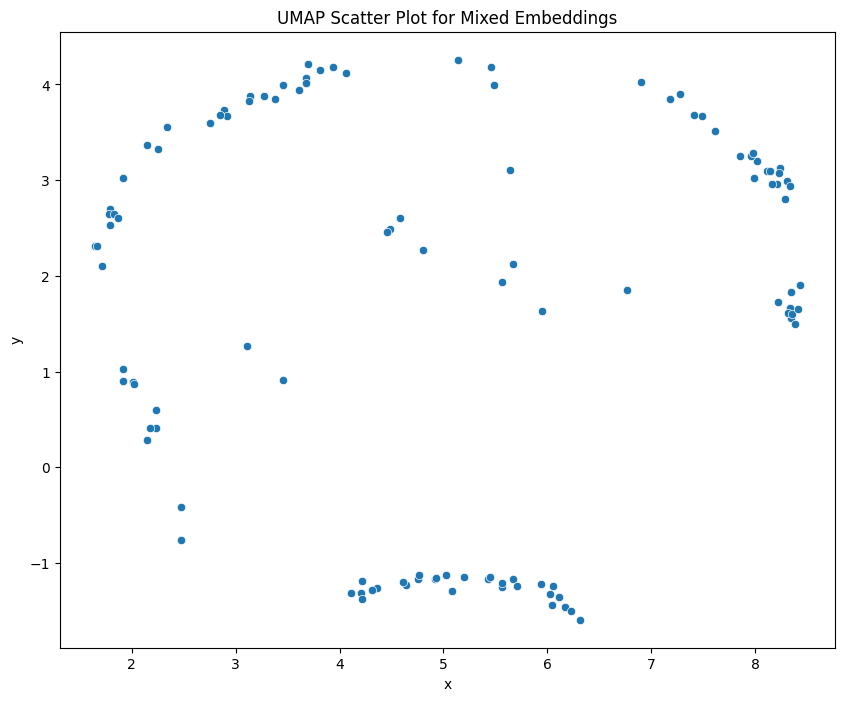

In [48]:
new_embeds = UMAP(n_neighbors=160, min_dist=0, metric='cosine', ).fit_transform(mixed_embeddings_landmarks_cpu)
# Create a DataFrame from the embeddings
df_embeds = pd.DataFrame(embeds, columns=['x', 'y'])




# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=df_embeds, x='x', y='y')
plt.title('UMAP Scatter Plot for Mixed Embeddings')

# # Adding text labels to the scatter plot
# for line in range(0, df_embeds.shape[0]):
#      scatter.text(df_embeds.x[line]+0.2, df_embeds.y[line], 
#      df_embeds.index[line], horizontalalignment='left', 
#      size='medium', color='black', weight='semibold')

plt.show()

In [49]:
new_embeds

array([[ 3.7516844 ,  3.404176  ],
       [ 3.8367133 ,  3.32818   ],
       [ 3.9179208 ,  3.3241658 ],
       [ 3.7648492 ,  3.2092102 ],
       [ 3.4734056 ,  3.120265  ],
       [ 3.3703597 ,  2.8421674 ],
       [ 3.2061846 ,  2.6824365 ],
       [ 3.0055754 ,  2.4787767 ],
       [ 2.9247131 ,  2.4264529 ],
       [ 2.8254762 ,  2.3087974 ],
       [ 2.623611  ,  2.1526964 ],
       [ 2.7749472 ,  2.2596781 ],
       [ 2.5632582 ,  2.0492668 ],
       [ 2.4331272 ,  2.127741  ],
       [ 2.487679  ,  2.216454  ],
       [ 2.284274  ,  2.0712404 ],
       [ 2.0478184 ,  1.965835  ],
       [ 2.0058312 ,  1.9525663 ],
       [ 1.9308444 ,  1.8755383 ],
       [ 1.6980326 ,  1.952927  ],
       [ 1.6072769 ,  2.0990918 ],
       [ 1.7457626 ,  1.9936373 ],
       [ 1.499795  ,  2.1374996 ],
       [ 1.3264823 ,  2.3162878 ],
       [ 1.0684608 ,  2.4814124 ],
       [ 0.4227477 ,  3.0053163 ],
       [ 0.14541788,  3.251055  ],
       [-0.05864011,  3.3883984 ],
       [-0.0486112 ,

<Axes: xlabel='x', ylabel='y'>

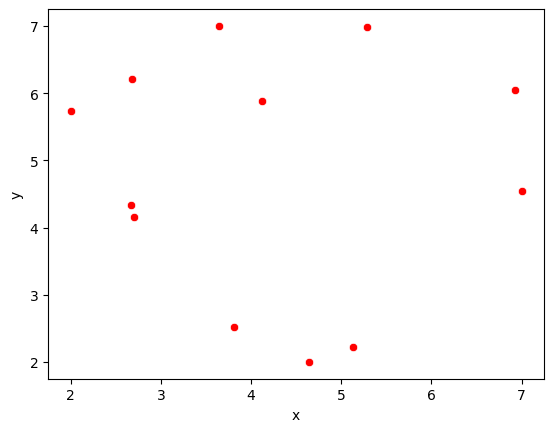

In [50]:
sns.scatterplot(data=df_scaled_heart, x='x', y='y', color='red')